In [1]:
import numpy as np 
import pandas as pd
import tmap as tm

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.AtomPairs import Pairs
from mxfp import mxfp
from map4 import MAP4Calculator
from mhfp.encoder import MHFPEncoder
from sklearn.neighbors import NearestNeighbors

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from faerun import Faerun
from drfp import DrfpEncoder

from tqdm import tqdm
tqdm.pandas()

#### Clean dataset (kekulization, remove duplicates)

In [2]:
df = pd.read_csv('data/zinc_fda.csv')

df['ROMol'] = df.smiles.apply(Chem.MolFromSmiles)
df['smiles'] = df.ROMol.apply(lambda x: Chem.MolToSmiles(x, kekuleSmiles=True))
df = df.drop_duplicates(subset=['smiles'])

Add molecular properties

In [3]:
df['MW'] = df.ROMol.apply(rdMolDescriptors.CalcExactMolWt)
df['HAC'] = df.ROMol.apply(rdMolDescriptors.CalcNumHeavyAtoms)
df['FCsp3'] = df.ROMol.apply(rdMolDescriptors.CalcFractionCSP3)

#### Calculate fingerprints 

In [4]:
MAP4 = MAP4Calculator(dimensions=2048)
MHFP6 = MHFPEncoder(n_permutations=2048)
MXFP = mxfp.MXFPCalculator(dimensionality='2D')

In [5]:
df['MXFP'] = df.ROMol.progress_apply(MXFP.mxfp_from_mol)
df['AP'] = df.ROMol.progress_apply(Pairs.GetAtomPairFingerprintAsBitVect)
df['MAP4'] = df.ROMol.progress_apply(MAP4.calculate)
df['MHFP6'] = df.smiles.progress_apply(MHFP6.encode)
df['ECFP4'] = df.ROMol.progress_apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2)) 
df['ECFP6'] = df.ROMol.progress_apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 3)) 
df['MACCS'] = df.ROMol.progress_apply(rdMolDescriptors.GetMACCSKeysFingerprint)
df['MQN'] = df.ROMol.progress_apply(rdMolDescriptors.MQNs_)

100%|██████████| 1614/1614 [00:00<00:00, 13371.98it/s]


#### Determine pairwise distances between every molecule

Define helper functions for different distance metrics:
1. Minhash distance for MAP4
2. Jaccard distance for MHFP6
3. Manhattan distance for MXFP (2D and 3D) and MQN
4. Tanimoto distance as implemented in RDKit for MACCS, ECFP4, ECFP6
5. Dice for AP

In [6]:
ENC = tm.Minhash(2048)

def jaccard(a, b):
    return ENC.get_distance(a, b)

def mhfp(a, b):
    return 1.0 - float(np.count_nonzero(a == b)) / float(len(a))

def manhattan(a, b):
    return sum(abs(np.array(a) - np.array(b)))

def rdkit(a, b):
    return 1.0 - DataStructs.FingerprintSimilarity(a, b)

def dice(a, b):
    return 1.0 - DataStructs.DiceSimilarity(a, b)

Define helper function to generate (n molecules) x (n molecules) matrix of pairwise similarities

In [7]:
def PairwiseDistanceList(fp_list, metric):
    distance_list = []
    for i in range(len(fp_list)):
        for j in range(len(fp_list)):
            distance_list.append(metric(fp_list[i], fp_list[j]))
    return distance_list

Define MinMax scaler (for MXFP and MQN)

In [8]:
def MinMax(matrix):
    return (matrix-np.min(matrix))/(np.max(matrix)-np.min(matrix))

Generate list of fingerprint for each fingerprint

In [9]:
mxfp2d = df.MXFP.values.tolist()
ap = df.AP.values.tolist()
map4 = df.MAP4.values.tolist()
mhfp6 = df.MHFP6.values.tolist()
ecfp4 = df.ECFP4.values.tolist()
ecfp6 = df.ECFP6.values.tolist()
maccs = df.MACCS.values.tolist()
mqn = df.MQN.values.tolist()

Generate pairwise distances of every molecular pair for every fingerprint

In [10]:
mxfp2d_distlist = PairwiseDistanceList(mxfp2d, manhattan)
ap_distlist = PairwiseDistanceList(ap, dice)
map4_distlist = PairwiseDistanceList(map4, jaccard) 
mhfp6_distlist = PairwiseDistanceList(mhfp6, mhfp) 
ecfp4_distlist = PairwiseDistanceList(ecfp4, dice)
ecfp6_distlist = PairwiseDistanceList(ecfp6, dice)
maccs_distlist = PairwiseDistanceList(maccs, dice) #from rdkit to dice
mqn_distlist = PairwiseDistanceList(mqn, manhattan)

Normalize MXFP and MQN distances (MinMax normalization between 0 and 1)

In [11]:
mxfp2d_distlist = MinMax(mxfp2d_distlist)
mqn_distlist = MinMax(mqn_distlist)

Plot distribution of distances for xLOS and every fingerprint

In [12]:
df_violin = pd.DataFrame(list(zip(mxfp2d_distlist, ap_distlist, map4_distlist, mhfp6_distlist, ecfp4_distlist, ecfp6_distlist, maccs_distlist, mqn_distlist)), 
                        columns=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'])

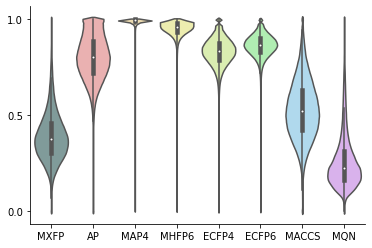

In [13]:
ax = sns.violinplot(data=df_violin, scale='count', palette=sns.color_palette(['#7B9F9E', '#F4A7A7', '#F5DEA6', '#F7F7A5', '#DEF7A7', '#A6F7A8', '#A6DDF7', '#DCA8F6']))

sns.set(rc={'figure.figsize':(16, 8)})
sns.set(font_scale=2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/fda_approved_distance_distributions.pdf', bbox_inches='tight')

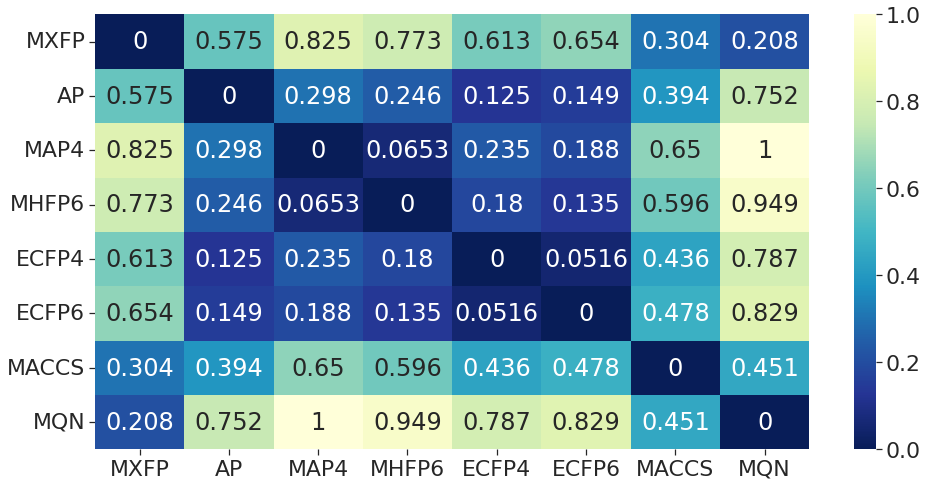

In [14]:
distance_matrices_list = [mxfp2d_distlist, ap_distlist, map4_distlist, mhfp6_distlist, ecfp4_distlist, ecfp6_distlist, maccs_distlist, mqn_distlist]
nn_distance_matrix = np.zeros((len(distance_matrices_list), len(distance_matrices_list)))

for i in range(len(distance_matrices_list)):
    for j in range(len(distance_matrices_list)):
        nn_distance_matrix[i, j] = np.linalg.norm(np.array(distance_matrices_list[i]) - np.array(distance_matrices_list[j]))

nn_distance_matrix = MinMax(nn_distance_matrix)
pairwise_matrix = pd.DataFrame(nn_distance_matrix, 
                                columns=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'], 
                                index=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'])

ax = sns.heatmap(pairwise_matrix, annot=True, fmt='.3g', cmap="YlGnBu_r")
plt.savefig('plots/fda_approved_euclidean_distances_heatmap.pdf', bbox_inches='tight')

Generate ranked matrices for every fingerprint. (Every column (=compound) has their distances ranked from closest to farthest)

In [15]:
mxfp2d_rankmat = pd.DataFrame(np.array(mxfp2d_distlist).reshape(len(mxfp2d), len(mxfp2d)).T).rank(method='average')
ap_rankmat = pd.DataFrame(np.array(ap_distlist).reshape(len(ap), len(ap)).T).rank(method='average')
map4_rankmat = pd.DataFrame(np.array(map4_distlist).reshape(len(map4), len(map4)).T).rank(method='average')
mhfp6_rankmat = pd.DataFrame(np.array(mhfp6_distlist).reshape(len(mhfp6), len(mhfp6)).T).rank(method='average')
ecfp4_rankmat = pd.DataFrame(np.array(ecfp4_distlist).reshape(len(ecfp4), len(ecfp4)).T).rank(method='average')
ecfp6_rankmat = pd.DataFrame(np.array(ecfp6_distlist).reshape(len(ecfp6), len(ecfp6)).T).rank(method='average')
maccs_rankmat = pd.DataFrame(np.array(maccs_distlist).reshape(len(maccs), len(maccs)).T).rank(method='average')
mqn_rankmat = pd.DataFrame(np.array(mqn_distlist).reshape(len(mqn), len(mqn)).T).rank(method='average')

In [16]:
mxfp2d_rank_flat = mxfp2d_rankmat.to_numpy().flatten()
ap_rank_flat = ap_rankmat.to_numpy().flatten()
map4_rank_flat = map4_rankmat.to_numpy().flatten()
mhfp6_rank_flat = mhfp6_rankmat.to_numpy().flatten()
ecfp4_rank_flat = ecfp4_rankmat.to_numpy().flatten()
ecfp6_rank_flat = ecfp6_rankmat.to_numpy().flatten()
maccs_rank_flat = maccs_rankmat.to_numpy().flatten()
mqn_rank_flat = mqn_rankmat.to_numpy().flatten()

df_rank_violin = pd.DataFrame(list(zip(mxfp2d_rank_flat, ap_rank_flat, map4_rank_flat, mhfp6_rank_flat, ecfp4_rank_flat, ecfp6_rank_flat, maccs_rank_flat, mqn_rank_flat)), 
                            columns=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'])

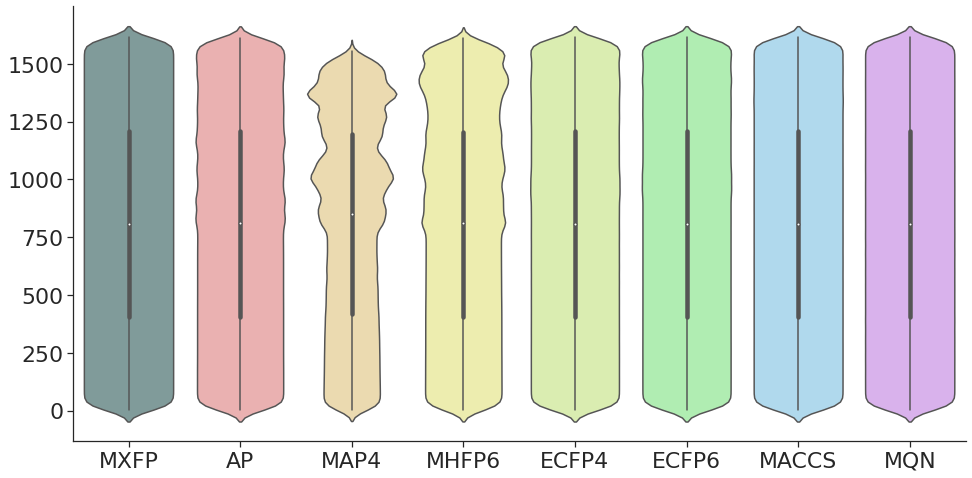

In [17]:
ax = sns.violinplot(data=df_rank_violin, scale='count', palette=sns.color_palette(['#7B9F9E', '#F4A7A7', '#F5DEA6', '#F7F7A5', '#DEF7A7', '#A6F7A8', '#A6DDF7', '#DCA8F6']))

sns.set(rc={'figure.figsize':(16, 8)})
sns.set(font_scale=2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/fda_approved_ranking_distributions.pdf', bbox_inches='tight')

Pairwise Euclidean distance between all matrices

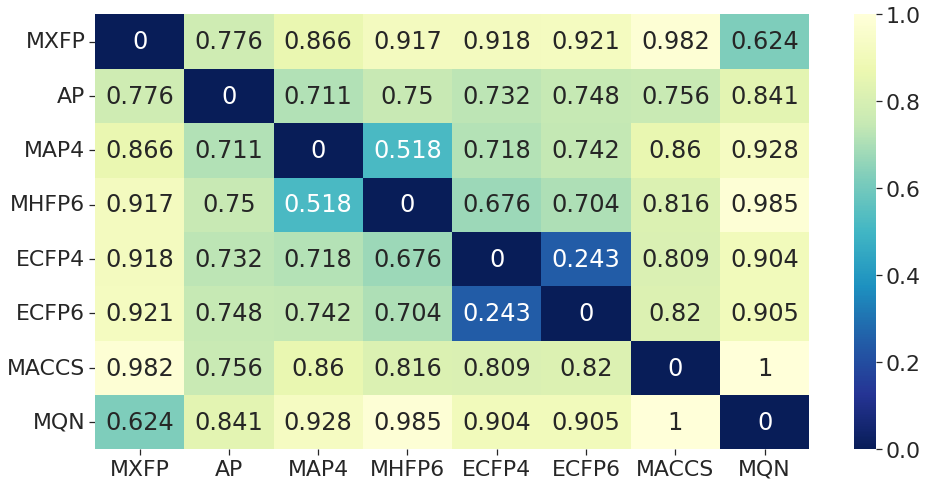

In [18]:
ranked_matrices_list = [mxfp2d_rankmat, ap_rankmat, map4_rankmat, mhfp6_rankmat, ecfp4_rankmat, ecfp6_rankmat, maccs_rankmat, mqn_rankmat]
nn_distance_matrix = np.zeros((len(ranked_matrices_list), len(ranked_matrices_list)))

for i in range(len(ranked_matrices_list)):
    for j in range(len(ranked_matrices_list)):
        nn_distance_matrix[i, j] = np.linalg.norm(ranked_matrices_list[i] - ranked_matrices_list[j])

nn_distance_matrix = MinMax(nn_distance_matrix)
pairwise_matrix = pd.DataFrame(nn_distance_matrix, 
                                columns=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'], 
                                index=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'])

ax = sns.heatmap(pairwise_matrix, annot=True, fmt='.3g', cmap="YlGnBu_r")
plt.savefig('plots/fda_approved_euclidean_pairwise_heatmap.pdf', bbox_inches='tight')

#### TMAP visualization

Define a function that fills a quadratic matrix of arbitrary length with empty strings

In [19]:
def EmptyStringMatrix(length):

    empty_string_matrix = []

    for i in range(length):
        empty_string_list = []
        for j in range(length):
            empty_string_list.append('')
        empty_string_matrix.append(empty_string_list)
    
    return empty_string_matrix

Define a function that generate all possible unique pairs of SMILES displayed as reaction SMILES

In [20]:
smiles_list = df.smiles.values.tolist()

def PairwiseReactionSMILES(smiles_list):

    pwrs = EmptyStringMatrix(len(smiles_list))

    for i in range(len(smiles_list)):
        for j in range(i, len(smiles_list)):
            pwrs[i][j] = f'{smiles_list[i]}>>{smiles_list[j]}'
            pwrs[j][i] = f'{smiles_list[i]}>>{smiles_list[j]}'
    
    return pwrs

reaction_smiles = PairwiseReactionSMILES(smiles_list)

Prepare pandas dataframes of distance matrices

In [21]:
mxfp2d_distance = pd.DataFrame(np.array(mxfp2d_distlist).reshape(len(mxfp2d), len(mxfp2d)).T)
ap_distance = pd.DataFrame(np.array(ap_distlist).reshape(len(ap), len(ap)).T)
map4_distance = pd.DataFrame(np.array(map4_distlist).reshape(len(map4), len(map4)).T)
mhfp6_distance = pd.DataFrame(np.array(mhfp6_distlist).reshape(len(mhfp6), len(mhfp6)).T)
ecfp4_distance = pd.DataFrame(np.array(ecfp4_distlist).reshape(len(ecfp4), len(ecfp4)).T)
ecfp6_distance = pd.DataFrame(np.array(ecfp6_distlist).reshape(len(ecfp6), len(ecfp6)).T)
maccs_distance = pd.DataFrame(np.array(maccs_distlist).reshape(len(maccs), len(maccs)).T)
mqn_distance = pd.DataFrame(np.array(mqn_distlist).reshape(len(mqn), len(mqn)).T)
pairwise_smiles = pd.DataFrame(reaction_smiles)

Calculate molecule pair properties

In [22]:
def PairwiseProperty(list_of_properties):

    pairwise_difference = np.zeros((len(list_of_properties), len(list_of_properties)))

    for i in range(len(list_of_properties)):
        for j in range(i, len(list_of_properties)):
            pairwise_difference[i, j] = (list_of_properties[i] + list_of_properties[j])/2
            pairwise_difference[j, i] = (list_of_properties[i] + list_of_properties[j])/2
    
    return pairwise_difference

In [23]:
pairwise_mw = pd.DataFrame(PairwiseProperty(df.MW.values.tolist()))
pairwise_hac = pd.DataFrame(PairwiseProperty(df.HAC.values.tolist()))
pairwise_fcsp3 = pd.DataFrame(PairwiseProperty(df.FCsp3.values.tolist()))

Generate tuple list for all of the dataframes

In [24]:
mxfp2d_tuples = (pd.concat([mxfp2d_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
ap_tuples = (pd.concat([ap_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
map4_tuples = (pd.concat([map4_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
mhfp6_tuples = (pd.concat([mhfp6_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
ecfp4_tuples = (pd.concat([ecfp4_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
ecfp6_tuples = (pd.concat([ecfp6_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
maccs_tuples = (pd.concat([maccs_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
mqn_tuples = (pd.concat([mqn_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())

For each fingerprint, sort and keep only top 20 for every compound (without self pairs). Concatenate the final lists

In [25]:
mxfp2d_top20 = pd.DataFrame(np.sort(mxfp2d_tuples.values, axis=0)).iloc[:20].to_numpy().flatten().tolist()
ap_top20 = pd.DataFrame(np.sort(ap_tuples.values, axis=0)).iloc[:20].to_numpy().flatten().tolist()
map4_top20 = pd.DataFrame(np.sort(map4_tuples.values, axis=0)).iloc[:20].to_numpy().flatten().tolist()
mhfp6_top20 = pd.DataFrame(np.sort(mhfp6_tuples.values, axis=0)).iloc[:20].to_numpy().flatten().tolist()
ecfp4_top20 = pd.DataFrame(np.sort(ecfp4_tuples.values, axis=0)).iloc[:20].to_numpy().flatten().tolist()
ecfp6_top20 = pd.DataFrame(np.sort(ecfp6_tuples.values, axis=0)).iloc[:20].to_numpy().flatten().tolist()
maccs_top20 = pd.DataFrame(np.sort(maccs_tuples.values, axis=0)).iloc[:20].to_numpy().flatten().tolist()
mqn_top20 = pd.DataFrame(np.sort(mqn_tuples.values, axis=0)).iloc[:20].to_numpy().flatten().tolist()

In [26]:
def OriginFP(reaction_smiles, list_of_lists):

    fp = np.zeros(len(list_of_lists))

    for i in range(len(list_of_lists)):
        if reaction_smiles in list_of_lists[i]:
            fp[i] = 1
        else:
            fp[i] = 0
    
    return fp


def OriginFPString(origin_fp):

    fp_list = ['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN']
    fp_origin = ''

    for i in range(len(origin_fp)):
        if origin_fp[i] == 1:
            fp_origin = fp_origin + fp_list[i] + '; '
    
    return fp_origin

In [27]:
mxfp_smiles = pd.DataFrame(mxfp2d_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
ap_smiles = pd.DataFrame(ap_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
map4_smiles = pd.DataFrame(map4_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
mhfp_smiles = pd.DataFrame(mhfp6_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
ecfp4_smiles = pd.DataFrame(ecfp4_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
ecfp6_smiles = pd.DataFrame(ecfp6_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
maccs_smiles = pd.DataFrame(maccs_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
mqn_smiles = pd.DataFrame(mqn_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()

In [28]:
top20_flat = mxfp2d_top20 + ap_top20 + map4_top20 + mhfp6_top20 + ecfp4_top20 + ecfp6_top20 + maccs_top20 + mqn_top20
top20_list = [mxfp_smiles, ap_smiles, map4_smiles, mhfp_smiles, ecfp4_smiles, ecfp6_smiles, maccs_smiles, mqn_smiles]

In [29]:
df_tmap = pd.DataFrame(top20_flat, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3'])
df_tmap = df_tmap.drop_duplicates(subset=['ReactionSMILES'])

In [30]:
df_tmap['OriginFP'] = df_tmap.ReactionSMILES.progress_apply(lambda x: OriginFP(x, top20_list))
df_tmap['ConsensusScore'] = df_tmap.OriginFP.progress_apply(np.sum)

100%|██████████| 82873/82873 [00:00<00:00, 415632.32it/s]


In [31]:
df_tmap['OriginFPString'] = df_tmap.OriginFP.progress_apply(OriginFPString)

100%|██████████| 82873/82873 [00:00<00:00, 484623.23it/s]


Define function for merged MinHashed fingerprints

In [32]:
def MergeMAP4(reaction_smiles):

    fp1, fp2 = reaction_smiles.split('>>')
    mol1 = Chem.MolFromSmiles(fp1)
    mol2 = Chem.MolFromSmiles(fp2)

    return MHFP6.merge(MAP4.calculate(mol1), MAP4.calculate(mol2))

Calculate merged MAP4 for all molecular pairs

In [33]:
df_tmap['MAP4'] = df_tmap.ReactionSMILES.progress_apply(MergeMAP4)

100%|██████████| 82873/82873 [29:29<00:00, 46.83it/s]  


In [34]:
rxn_smiles = df_tmap['ReactionSMILES'].values.tolist()
df_tmap['DRFP'] = DrfpEncoder.encode(rxn_smiles)

: 

TMAP

Layout

In [ ]:
lf = tm.LSHForest(1024, 64)

merged_map4 = np.array(df_tmap['MAP4'])
fps = []

for i in merged_map4:
    vec = tm.VectorUint(i)
    fps.append(vec)

lf.batch_add(fps)
lf.index()

cfg = tm.LayoutConfiguration() #configuration parameters for tmap layout
cfg.node_size = 1 / 50 #size of nodes which affects the magnitude of their repelling force. Decreasing this values generally resolves overlaps in a very crowded tree
cfg.mmm_repeats = 2 #number of repeats of the per-level layout algorithm
cfg.sl_extra_scaling_steps = 5 #sets the number of repeats of the scaling
cfg.k = 45 #number of nearest neighbours used to create the k-nearest neighbour graph
cfg.sl_scaling_type = tm.RelativeToAvgLength #Defines the relative scale of the graph
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

Colormaps and customized labels

In [ ]:
from matplotlib import cm

rainbow_8 = cm.get_cmap('rainbow', 8)

In [ ]:
labels = []

for i, row in df_tmap.iterrows():
    labels.append(
            row["ReactionSMILES"]
            + "__"
            + f'{row["ReactionSMILES"]}'
            + "__"
            + f'Found in: {row["OriginFPString"]}'
            + "__"
            + f'MXFP: {row["MXFP2D_distance"]}'
            + "__"
            + f'AP: {row["AP_distance"]}'
            + "__"
            + f'MAP4: {row["MAP4_distance"]}'
            + "__"
            + f'MHFP6: {row["MHFP6_distance"]}'
            + "__"
            + f'ECFP4: {row["ECFP4_distance"]}'
            + "__"
            + f'ECFP6: {row["ECFP6_distance"]}'
            + "__"
            + f'MACCS: {row["MACCS_distance"]}'
            + "__"
            + f'MQN: {row["MQN_distance"]}'
        )

Labels of sets

In [ ]:
set_labels, set_data = Faerun.create_categories(df_tmap['ConsensusScore'])

In [ ]:
f = Faerun(
    view="front", 
    coords=False,
    title="",
    clear_color='#FFFFFF',
)

f.add_scatter(
    "MAP4_TMAP",
    {
        "x": x,
        "y": y,
        "c": [
            df_tmap.μMW.values.tolist(),
            df_tmap.μHAC.values.tolist(), 
            df_tmap.μFCsp3.values.tolist(),
            df_tmap.MXFP2D_distance.values.tolist(),
            df_tmap.AP_distance.values.tolist(),
            df_tmap.MAP4_distance.values.tolist(),
            df_tmap.MHFP6_distance.values.tolist(),
            df_tmap.ECFP4_distance.values.tolist(),
            df_tmap.ECFP6_distance.values.tolist(),
            df_tmap.MACCS_distance.values.tolist(),
            df_tmap.MQN_distance.values.tolist(),
            set_data,
            ],
        "labels": labels,
    },
    shader="sphere",
    point_scale=2,
    max_point_size=20,
    legend_labels=[None, None, None, None, None, None, None, None, None, None, None, set_labels],
    categorical=[False, False, False, False, False, False, False, False, False, False, False, True],
    colormap=['rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', rainbow_8],
    series_title=['μMW', 'μHAC', 'μFCsp3', 'MXFP_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ConsensusScore'],
    has_legend=True,
)
f.add_tree("MAP4_TMAP_tree", {"from": s, "to": t}, point_helper="MAP4_TMAP")
f.plot('plots/fda_approved_MAP4_TMAP', template='reaction_smiles')

#### DRFP TMAP

In [ ]:
lf = tm.LSHForest(1024, 64)

merged_map4 = np.array(df_tmap['DRFP'])
fps = []

for i in merged_map4:
    vec = tm.VectorUint(i)
    fps.append(vec)

lf.batch_add(fps)
lf.index()

cfg = tm.LayoutConfiguration() #configuration parameters for tmap layout
cfg.node_size = 1 / 50 #size of nodes which affects the magnitude of their repelling force. Decreasing this values generally resolves overlaps in a very crowded tree
cfg.mmm_repeats = 2 #number of repeats of the per-level layout algorithm
cfg.sl_extra_scaling_steps = 5 #sets the number of repeats of the scaling
cfg.k = 45 #number of nearest neighbours used to create the k-nearest neighbour graph
cfg.sl_scaling_type = tm.RelativeToAvgLength #Defines the relative scale of the graph
x_drfp, y_drfp, s_drfp, t_drfp, _ = tm.layout_from_lsh_forest(lf, cfg)

In [ ]:
from matplotlib import cm

rainbow_8 = cm.get_cmap('rainbow', 8)

In [ ]:
labels = []

for i, row in df_tmap.iterrows():
    labels.append(
            row["ReactionSMILES"]
            + "__"
            + f'{row["ReactionSMILES"]}'
            + "__"
            + f'Found in: {row["OriginFPString"]}'
            + "__"
            + f'MXFP: {row["MXFP2D_distance"]}'
            + "__"
            + f'AP: {row["AP_distance"]}'
            + "__"
            + f'MAP4: {row["MAP4_distance"]}'
            + "__"
            + f'MHFP6: {row["MHFP6_distance"]}'
            + "__"
            + f'ECFP4: {row["ECFP4_distance"]}'
            + "__"
            + f'ECFP6: {row["ECFP6_distance"]}'
            + "__"
            + f'MACCS: {row["MACCS_distance"]}'
            + "__"
            + f'MQN: {row["MQN_distance"]}'
        )

In [ ]:
set_labels, set_data = Faerun.create_categories(df_tmap['ConsensusScore'])

In [ ]:
f = Faerun(
    view="front", 
    coords=False,
    title="",
    clear_color='#FFFFFF',
)

f.add_scatter(
    "DRFP_TMAP",
    {
        "x": x,
        "y": y,
        "c": [
            df_tmap.μMW.values.tolist(),
            df_tmap.μHAC.values.tolist(), 
            df_tmap.μFCsp3.values.tolist(),
            df_tmap.MXFP2D_distance.values.tolist(),
            df_tmap.AP_distance.values.tolist(),
            df_tmap.MAP4_distance.values.tolist(),
            df_tmap.MHFP6_distance.values.tolist(),
            df_tmap.ECFP4_distance.values.tolist(),
            df_tmap.ECFP6_distance.values.tolist(),
            df_tmap.MACCS_distance.values.tolist(),
            df_tmap.MQN_distance.values.tolist(),
            set_data,
            ],
        "labels": labels,
    },
    shader="sphere",
    point_scale=2,
    max_point_size=20,
    legend_labels=[None, None, None, None, None, None, None, None, None, None, None, set_labels],
    categorical=[False, False, False, False, False, False, False, False, False, False, False, True],
    colormap=['rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', rainbow_8],
    series_title=['μMW', 'μHAC', 'μFCsp3', 'MXFP_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ConsensusScore'],
    has_legend=True,
)
f.add_tree("DRFP_TMAP_tree", {"from": s, "to": t}, point_helper="DRFP_TMAP")
f.plot('plots/fda_approved_DRFP_TMAP', template='reaction_smiles')

#### TMAP of molecules

In [ ]:
lf = tm.LSHForest(1024, 64)

merged_map4 = np.array(df['MAP4'])
fps = []

for i in merged_map4:
    vec = tm.VectorUint(i)
    fps.append(vec)

lf.batch_add(fps)
lf.index()

cfg = tm.LayoutConfiguration() #configuration parameters for tmap layout
cfg.node_size = 1 / 30 #size of nodes which affects the magnitude of their repelling force. Decreasing this values generally resolves overlaps in a very crowded tree
cfg.mmm_repeats = 2 #number of repeats of the per-level layout algorithm
cfg.sl_extra_scaling_steps = 5 #sets the number of repeats of the scaling
cfg.k = 45 #number of nearest neighbours used to create the k-nearest neighbour graph
cfg.sl_scaling_type = tm.RelativeToAvgLength #Defines the relative scale of the graph
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

In [ ]:
def FindSelections(smiles):
    if smiles == 'C[C@H](C(=O)O)C1=CC=CC(C(=O)C2=CC=CC=C2)=C1':
        return '1 - Dexketoprophen'
    elif smiles == 'O=C(C1=CC=CC=C1)C1=CC=C2[C@@H](C(=O)O)CCN12':
        return '2 - (S)-Ketorolac'
    elif smiles == 'COC1=CC([C@@H]2C3=CC4=C(C=C3[C@H](O)[C@H]3COC(=O)[C@H]23)OCO4)=CC(OC)=C1OC':
        return '3 - Podophyllotoxin'
    elif smiles == 'COC1=CC2=C(C3=CC=C(OC)C(=O)C=C3[C@@H](NC(C)=O)CC2)C(OC)=C1OC':
        return '4 - Colchicine'
    elif smiles == 'CCCN(CCC)CCC1=CC=CC2=C1CC(=O)N2':
        return '5 - Ropinirole'
    elif smiles == 'CCCN(CCC1=CC=CS1)[C@H]1CCC2=C(O)C=CC=C2C1':
        return '6 - Rotigotine'
    elif smiles == 'CN(C)C/C=C/C(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)N=CN=C2C=C1O[C@H]1CCOC1':
        return '7 - Afatinib'
    elif smiles == 'C=CC(=O)NC1=CC(NC2=NC=CC(C3=CN(C)C4=CC=CC=C34)=N2)=C(OC)C=C1N(C)CCN(C)C':
        return '8 - Osimertinib'
    else:
        return 'Not selected'

def SphereSize(set_label):
    if set_label == 'Not selected':
        return 0.75
    else:
        return 1.5

In [ ]:
df['Selection'] = df.smiles.apply(FindSelections)
df['Size'] = df.Selection.apply(SphereSize)

selection_labels, selection_data = Faerun.create_categories(df['Selection'])
size_list = df['Size'].values.tolist()

In [ ]:
paired = ListedColormap(['#96C3DC', '#1C63A5', '#A4DB77', '#2B9322', '#F78588', '#D90016', '#BEA1CC', '#562888', '#D0D0D0'], name="paired")

In [ ]:
labels = []

for i, row in df.iterrows():
    labels.append(
            row["smiles"]
            + "__"
            + f'{row["smiles"]}'
        )

In [ ]:
f = Faerun(
    view="front", 
    coords=False,
    title="",
    clear_color='#FFFFFF',
)

f.add_scatter(
    "MAP4_TMAP",
    {
        "x": x,
        "y": y,
        "c": [
            df.MW.values.tolist(),
            df.HAC.values.tolist(), 
            df.FCsp3.values.tolist(),
            selection_data
            ],
        "s": [size_list, 
            size_list,
            size_list,
            size_list,
            ],
        "labels": labels,
    },
    shader="sphere",
    point_scale=8,
    max_point_size=20,
    legend_labels=[None, None, None, selection_labels],
    categorical=[False, False, False, True],
    colormap=['rainbow_r', 'rainbow_r', 'rainbow_r', paired],
    series_title=['μMW', 'μHAC', 'μFCsp3', 'Selection'],
    has_legend=True,
)
f.add_tree("MAP4_TMAP_tree", {"from": s, "to": t}, point_helper="MAP4_TMAP")
f.plot('plots/fda_approved_mols_MAP4_TMAP', template='smiles')